# KNN

Take an example of KNN implementation (see below) and extend it in several different ways:


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,10)})

import warnings
warnings.filterwarnings('ignore')

Load the heart dataset.


In [2]:
df = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/heart.csv', skiprows=1)
df

thalach  oldpeak  target
0          0      2.3       1
1        187      3.5       1
2        172      1.4       1
3        178      0.8       1
4        163      0.6       1
..       ...      ...     ...
298      123      0.2       0
299      132      1.2       0
300      141      3.4       0
301      115      1.2       0
302      174      0.0       0

[303 rows x 3 columns]

Remove outliers


In [3]:
import scipy.stats as stats

z = np.abs(stats.zscore(df))

d = df[(z<3).all(axis=1)].reset_index(drop=True)

d.shape


(299, 3)

In [4]:
d

thalach  oldpeak  target
0        187      3.5       1
1        172      1.4       1
2        178      0.8       1
3        163      0.6       1
4        148      0.4       1
..       ...      ...     ...
294      123      0.2       0
295      132      1.2       0
296      141      3.4       0
297      115      1.2       0
298      174      0.0       0

[299 rows x 3 columns]

Scale data

In [5]:
d_num = d.drop('target', axis=1)
d_norm = (d_num-d_num.min())/(d_num.max()-d_num.min())
d_norm =  pd.concat((d_norm, d['target']), 1)
d_norm

thalach   oldpeak  target
0    0.868421  0.795455       1
1    0.736842  0.318182       1
2    0.789474  0.181818       1
3    0.657895  0.136364       1
4    0.526316  0.090909       1
..        ...       ...     ...
294  0.307018  0.045455       0
295  0.385965  0.272727       0
296  0.464912  0.772727       0
297  0.236842  0.272727       0
298  0.754386  0.000000       0

[299 rows x 3 columns]

In [6]:
d = d_norm

10-fold cross validation: Split the data into a training set (90%) and a test set (10%).


In [7]:
k_folds = 10
k_n = [1, 3, 5, 7, 9]

In [8]:
round(len(d)/k_folds) # n subjects per fold

30

In [9]:
d['fold'] = np.nan

start_idx = 0 

for fold in range(1, k_folds+1):
    d['fold'].loc[start_idx:start_idx+(round(len(d)/k_folds))] = int(fold)
    start_idx =+ start_idx+(round(len(d)/k_folds))
    
d

thalach   oldpeak  target  fold
0    0.868421  0.795455       1   1.0
1    0.736842  0.318182       1   1.0
2    0.789474  0.181818       1   1.0
3    0.657895  0.136364       1   1.0
4    0.526316  0.090909       1   1.0
..        ...       ...     ...   ...
294  0.307018  0.045455       0  10.0
295  0.385965  0.272727       0  10.0
296  0.464912  0.772727       0  10.0
297  0.236842  0.272727       0  10.0
298  0.754386  0.000000       0  10.0

[299 rows x 4 columns]

In [10]:
print(len(d[d['fold'] == 10]))

29


## Visualization

Design and implement a visualization scheme to visualize training data instances and testing instances in a 2D space.


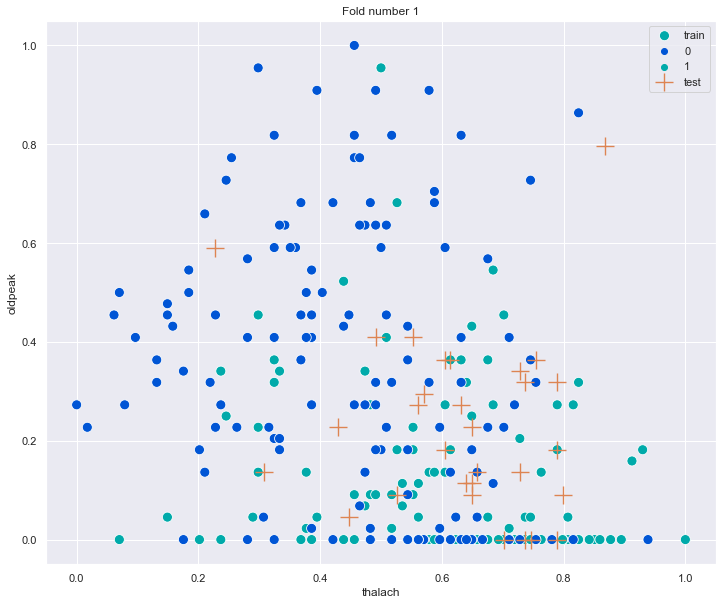

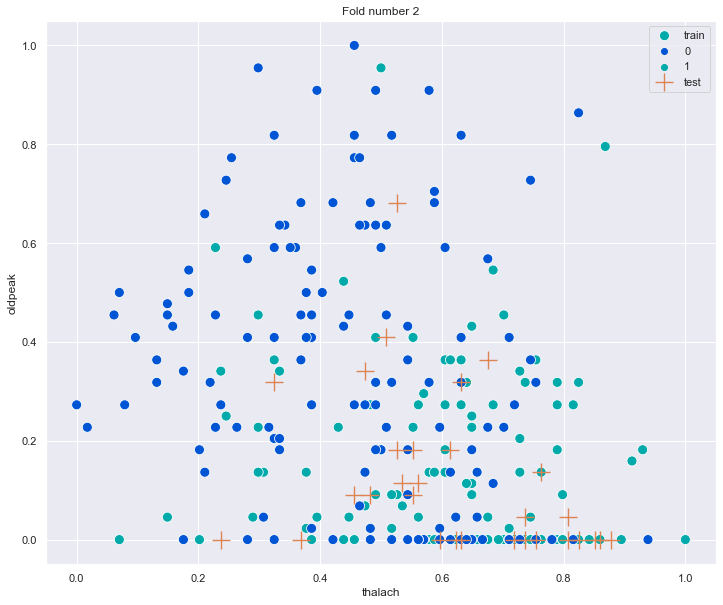

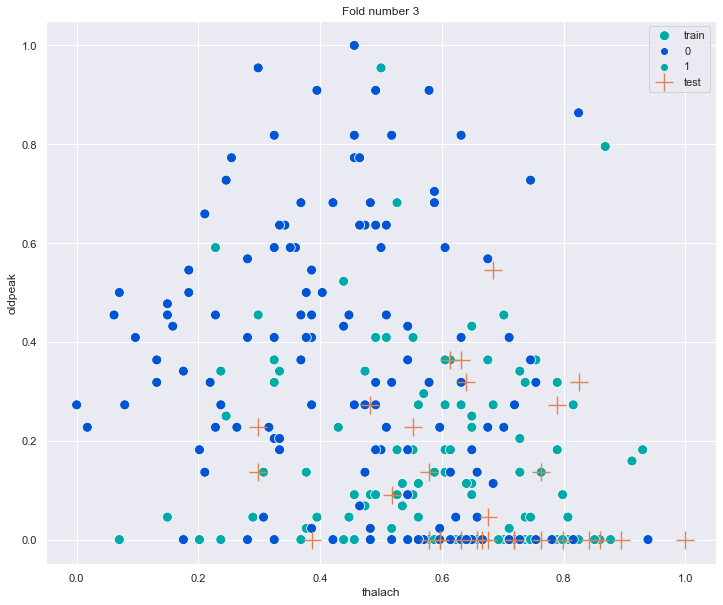

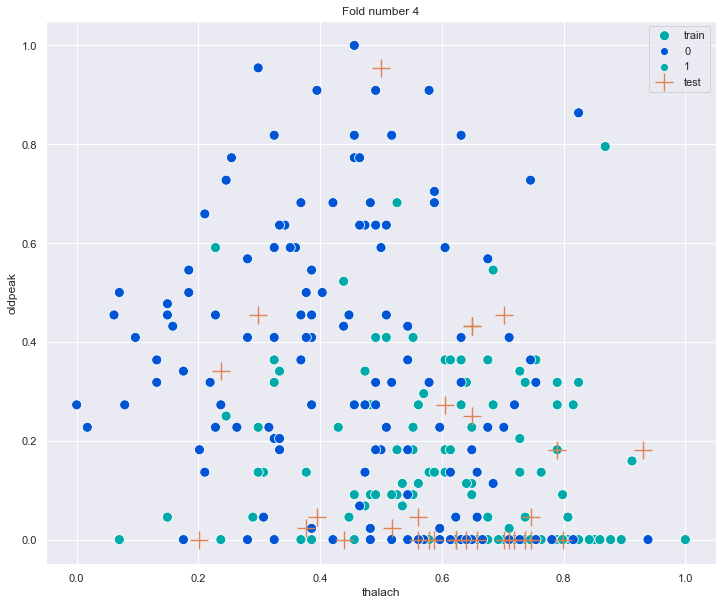

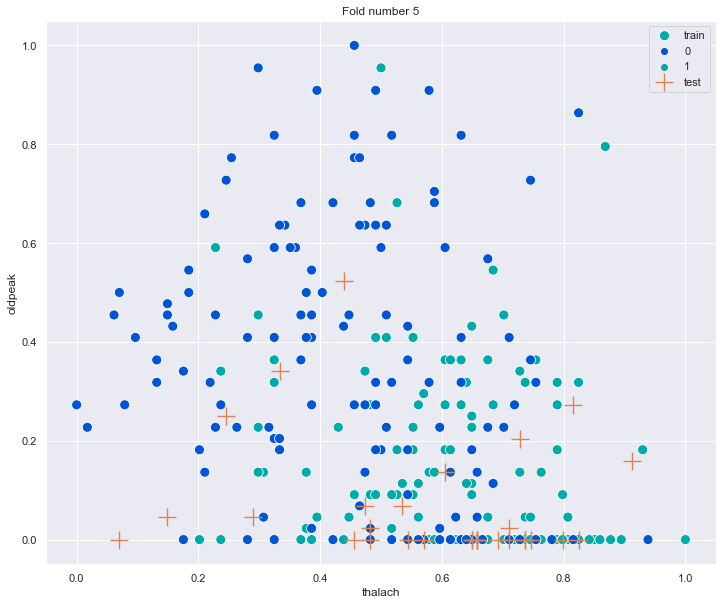

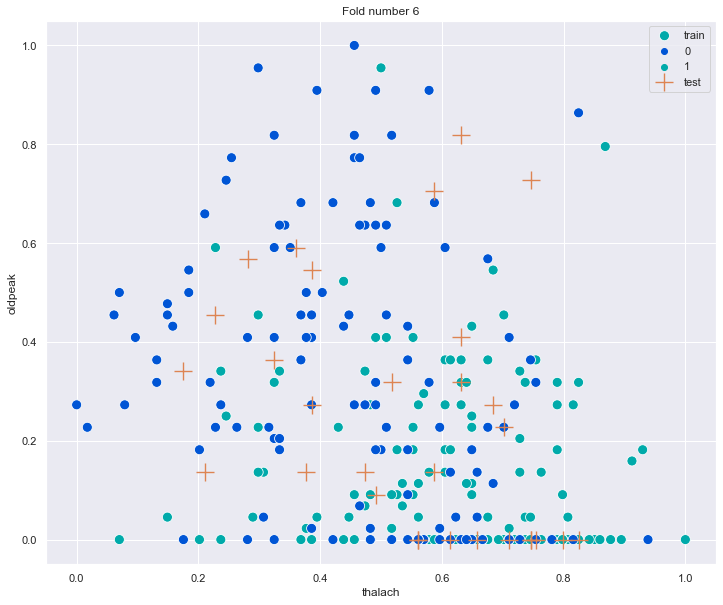

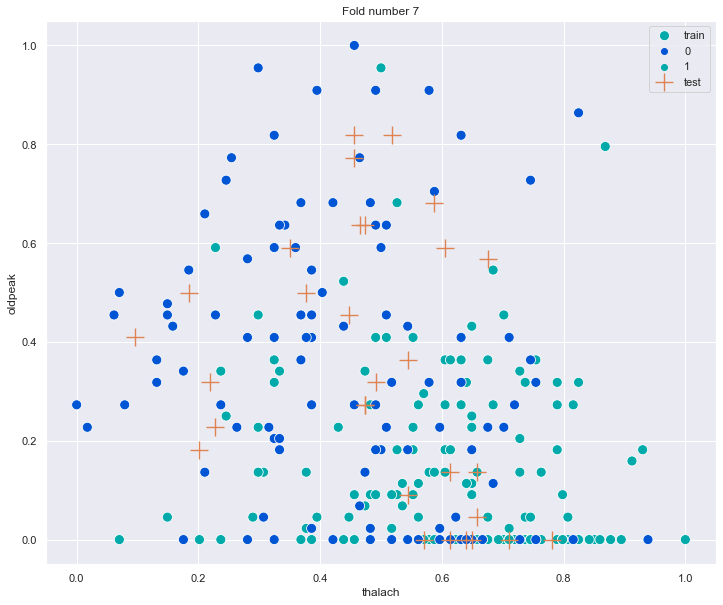

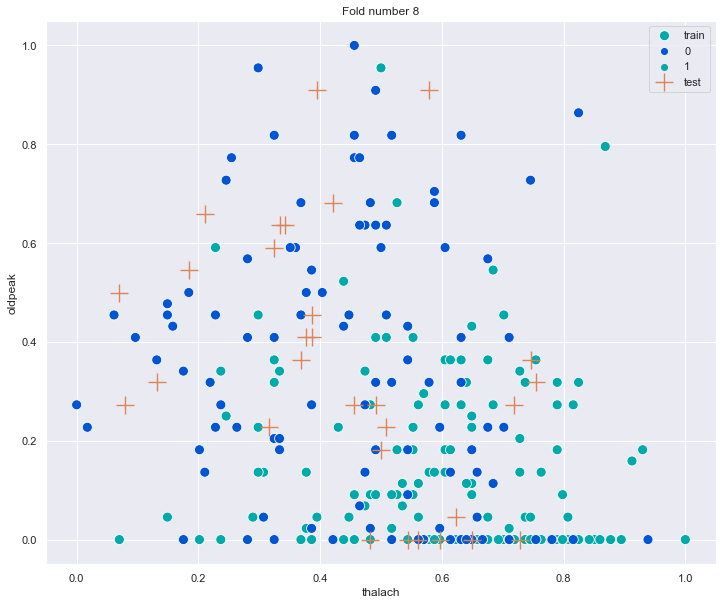

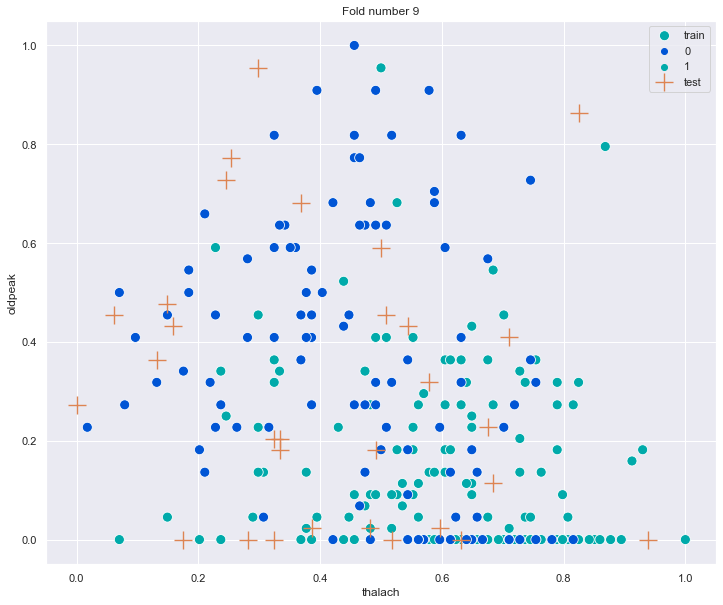

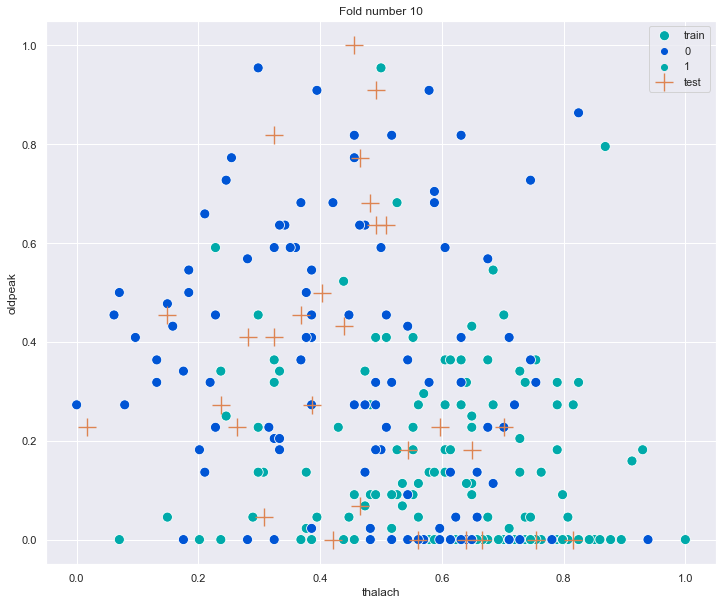

In [11]:
for fold in range(1, k_folds+1):
    test = d[d['fold'] == fold]
    train = d[d['fold'] != fold]
    
    fig, ax = plt.subplots()
    sns.scatterplot(data=train, x='thalach', y='oldpeak', hue = 'target', s=100, palette='winter', label = 'train', ax=ax)
    sns.scatterplot(data=test, x='thalach', y='oldpeak', s=300, palette='summer', label = 'test', marker = '+', ax=ax)
    plt.title('Fold number %s' % fold)
    plt.show()
    

Experiment with k=1,3,5,7 and 9, and show results in a precision-recall curve (with error bars generated by 10-fold cross validation).


In [12]:
fold=1
train_idx = np.where(d['fold'] != fold)
d[['thalach', 'oldpeak']].loc[train_idx]

thalach   oldpeak
30   0.456140  0.090909
31   0.877193  0.000000
32   0.561404  0.113636
33   0.324561  0.318182
34   0.631579  0.318182
..        ...       ...
294  0.307018  0.045455
295  0.385965  0.272727
296  0.464912  0.772727
297  0.236842  0.272727
298  0.754386  0.000000

[269 rows x 2 columns]

In [13]:
len(d)

299

## KNN Classification

In [14]:
from sklearn.neighbors import KNeighborsClassifier

pr = []
    
for k in k_n:
    d['prediction_k=%s' % str(k)] = np.nan
    d['correct_k=%s' % str(k)] = np.nan
    
    for fold in range(1, k_folds+1):

        train_idx = np.where(d['fold'] != fold)
        test_idx = np.where(d['fold'] == fold)   
    
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(d[['thalach', 'oldpeak']].loc[train_idx], d['target'].loc[train_idx])
        
        d['prediction_k=%s' % str(k)].loc[test_idx] = knn_model.predict(d[['thalach', 'oldpeak']].loc[test_idx])
        d['correct_k=%s' % str(k)].loc[test_idx] = np.where(d['prediction_k=%s' % str(k)].loc[test_idx] == d['target'].loc[test_idx], 1, 0)
        
        if k == 0: #only showing for one value of k
            fig, ax = plt.subplots()
            sns.scatterplot(data=d.loc[train_idx], x='thalach', y='oldpeak', hue = 'target', s=100, palette='winter', label = 'train', ax=ax)
            sns.scatterplot(data=d.loc[test_idx], x='thalach', y='oldpeak', hue = 'prediction_k=%s' % str(k), s=300, palette='summer', label = 'test', marker = '+', ax=ax)
            plt.title('Fold number %s' % fold)
            plt.show()
        
        # calculate true positives, false positives, false negatives
        tp = sum( np.where( (d['correct_k=%s' % str(k)] == 1) & (d['prediction_k=%s' % str(k)] == 1), 1, 0))
        fp = sum( np.where( (d['correct_k=%s' % str(k)] == 0) & (d['prediction_k=%s' % str(k)] == 1), 1, 0))
        fn = sum( np.where( (d['correct_k=%s' % str(k)] == 0) & (d['prediction_k=%s' % str(k)] == 0), 1, 0))

        # calculate precision and recall for each value of k
        pr.append([k, tp/(tp+fp), tp/(tp+fn)])


pr_df = pd.DataFrame(pr, columns = ['k', 'precision', 'recall'])

In [15]:
pr_mean = pr_df.groupby('k').mean()
pr_mean

pr_sd = pr_df.groupby('k').std()
pr_sd

pr_mean = pr_mean.join(pr_sd, lsuffix = '_mean', rsuffix = '_sd')

In [16]:
pr_mean

precision_mean  recall_mean  precision_sd  recall_sd
k                                                      
1        0.878899     0.581683      0.158878   0.018705
3        0.903552     0.665575      0.128925   0.059178
5        0.900529     0.637977      0.133636   0.088632
7        0.895519     0.665846      0.137093   0.059735
9        0.895245     0.676770      0.137354   0.047776

## Plot 1: Precision

x-axis: k (1, 3, 5…)

y-axis: precise value

error bar: generated from 10-fold (10 data points for each k value)

Text(0, 0.5, 'Precision')

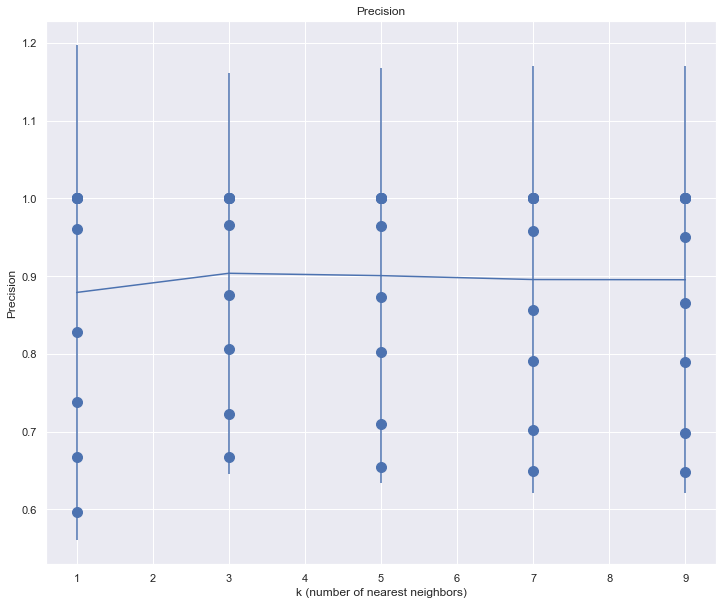

In [17]:
plt.scatter(data = pr_df, x = 'k', y = 'precision', s=100)
plt.errorbar(data = pr_mean.reset_index(), x = 'k', y = 'precision_mean', yerr = 2*pr_mean['precision_sd'])
plt.title("Precision")
plt.xlabel("k (number of nearest neighbors)")
plt.ylabel("Precision")

## Plot 2: Recall

x-axis: k (1, 3, 5…)

y-axis: recall value

error bar: generated from 10-fold (10 data points for each k value)

Text(0, 0.5, 'Recall')

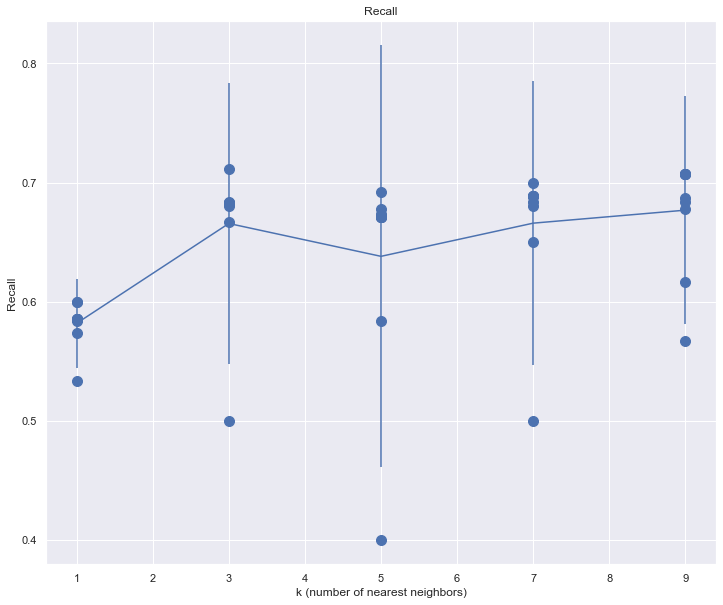

In [18]:
plt.scatter(data = pr_df, x = 'k', y = 'recall', s=100)
plt.errorbar(data = pr_mean.reset_index(), x = 'k', y = 'recall_mean', yerr = 2*pr_mean['recall_sd'])
plt.title("Recall")
plt.xlabel("k (number of nearest neighbors)")
plt.ylabel("Recall")

## Plot 3: Precision-Recall

x-axis: recall

y-axis: precise

no error bar

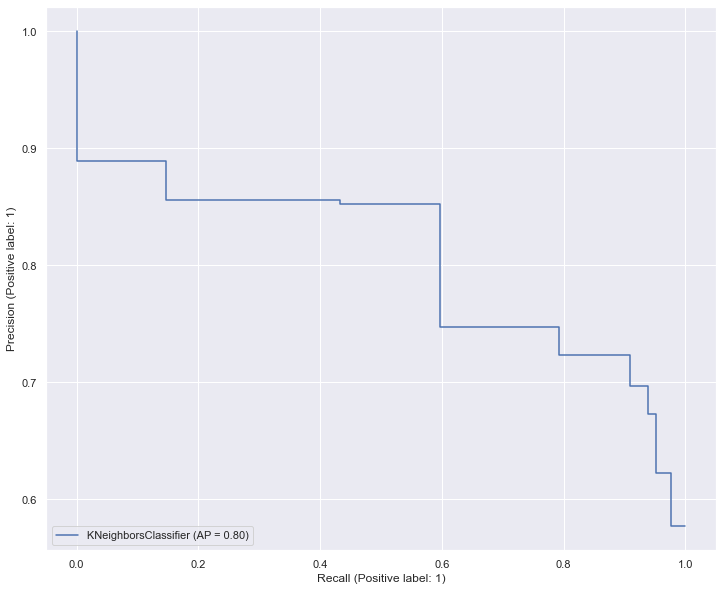

In [19]:
import sklearn

sklearn.metrics.plot_precision_recall_curve(knn_model, d[['thalach', 'oldpeak']], d['target'])

## Optional - weighted by inverse distance

(optional) Create a new version in which it labels new input based on a weighted sum (instead of majority vote) by taking distance into account. That is, those neighbors are closer to the input carry more weights (proportionally) than others.

(optional) implement your own version of KNN

In [20]:
pr_ = []
    
for k in k_n:
    d['prediction_k=%s' % str(k)] = np.nan
    d['correct_k=%s' % str(k)] = np.nan
    
    for fold in range(1, k_folds+1):

        train_idx = np.where(d['fold'] != fold)
        test_idx = np.where(d['fold'] == fold)   
    
        knn_model = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
        knn_model.fit(d[['thalach', 'oldpeak']].loc[train_idx], d['target'].loc[train_idx])
        
        d['prediction_k=%s' % str(k)].loc[test_idx] = knn_model.predict(d[['thalach', 'oldpeak']].loc[test_idx])
        d['correct_k=%s' % str(k)].loc[test_idx] = np.where(d['prediction_k=%s' % str(k)].loc[test_idx] == d['target'].loc[test_idx], 1, 0)
        
        if k == 0: #only showing for one value of k
            fig, ax = plt.subplots()
            sns.scatterplot(data=d.loc[train_idx], x='thalach', y='oldpeak', hue = 'target', s=100, palette='winter', label = 'train', ax=ax)
            sns.scatterplot(data=d.loc[test_idx], x='thalach', y='oldpeak', hue = 'prediction_k=%s' % str(k), s=300, palette='summer', label = 'test', marker = '+', ax=ax)
            plt.title('Fold number %s' % fold)
            plt.show()
        
        # calculate true positives, false positives, false negatives
        tp = sum( np.where( (d['correct_k=%s' % str(k)] == 1) & (d['prediction_k=%s' % str(k)] == 1), 1, 0))
        fp = sum( np.where( (d['correct_k=%s' % str(k)] == 0) & (d['prediction_k=%s' % str(k)] == 1), 1, 0))
        fn = sum( np.where( (d['correct_k=%s' % str(k)] == 0) & (d['prediction_k=%s' % str(k)] == 0), 1, 0))

        # calculate precision and recall for each value of k
        pr_.append([k, tp/(tp+fp), tp/(tp+fn)])


pr_df_ = pd.DataFrame(pr_, columns = ['k', 'precision', 'recall'])

In [21]:
pr_mean_ = pr_df_.groupby('k').mean()
pr_mean_

pr_sd_ = pr_df_.groupby('k').std()
pr_sd_

pr_mean_ = pr_mean_.join(pr_sd_, lsuffix = '_mean', rsuffix = '_sd')

In [22]:
pr_mean_

precision_mean  recall_mean  precision_sd  recall_sd
k                                                      
1        0.878899     0.581683      0.158878   0.018705
3        0.900108     0.605545      0.137697   0.026508
5        0.902592     0.612420      0.134489   0.040319
7        0.903477     0.628560      0.132332   0.047924
9        0.898896     0.629393      0.136128   0.048567

## Plot 1: Precision

x-axis: k (1, 3, 5…)

y-axis: precise value

error bar: generated from 10-fold (10 data points for each k value)

Text(0, 0.5, 'Precision')

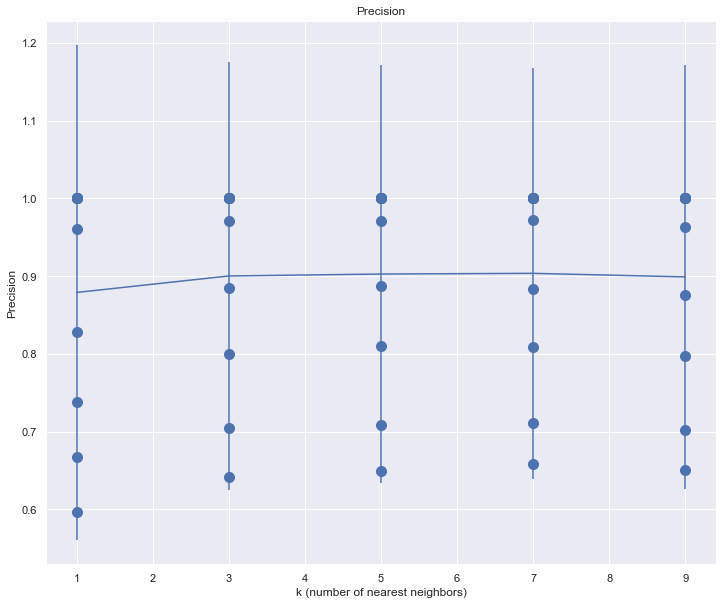

In [23]:
plt.scatter(data = pr_df_, x = 'k', y = 'precision', s=100)
plt.errorbar(data = pr_mean_.reset_index(), x = 'k', y = 'precision_mean', yerr = 2*pr_mean_['precision_sd'])
plt.title("Precision")
plt.xlabel("k (number of nearest neighbors)")
plt.ylabel("Precision")

## Plot 2: Recall

x-axis: k (1, 3, 5…)

y-axis: recall value

error bar: generated from 10-fold (10 data points for each k value)

Text(0, 0.5, 'Recall')

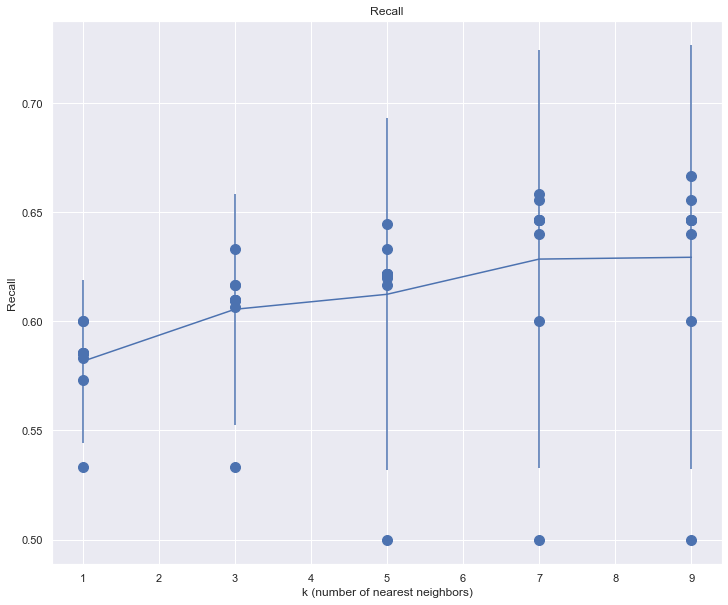

In [24]:
plt.scatter(data = pr_df_, x = 'k', y = 'recall', s=100)
plt.errorbar(data = pr_mean_.reset_index(), x = 'k', y = 'recall_mean', yerr = 2*pr_mean_['recall_sd'])
plt.title("Recall")
plt.xlabel("k (number of nearest neighbors)")
plt.ylabel("Recall")

## Plot 3: Precision-Recall

x-axis: recall

y-axis: precise

no error bar

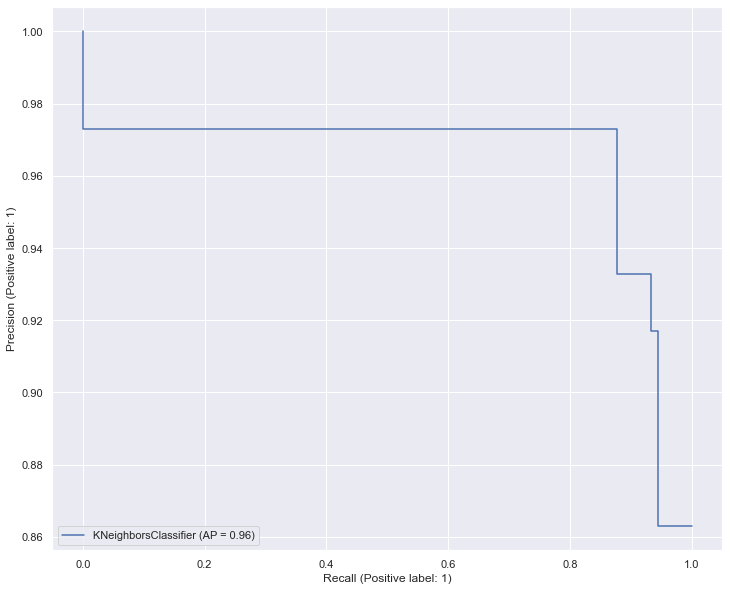

In [25]:
from sklearn.metrics import precision_recall_curve

sklearn.metrics.plot_precision_recall_curve(knn_model, d[['thalach', 'oldpeak']], d['target'])

## Report

Write a brief report including all the results, your interpretation and observation.  

Submit both implementation and report in a zipped file.

For this assignment, we applied a KNN classification algorithm on the heart dataset, which consisted of two features and a target classification outcome. First, outlier data points were removed by obtaining a z-score for all values and removing values with abs(z) > 3 (n=4). Data was normalized before applying the KNN classification algorithm with 10-fold CV. Values of k were manipulated (k=1,3,5,7,9) to determine which number of nearest neighbors provided the best classification result, as determined by precision and recall scores.

Results indicated that across values of k, precision scores slightly decreased from 3 to 9, but in general showed little change. k=5 showed a larger sd across the 10 folds. For recall, values tended to increase (for the most part) with higher values of k, with k=9 showing the highest mean recall (0.677) and lowest sd across the 10 folds (sd=0.048). k=9 would be a good choice to balance precision (0.895+/-.137) and recall. 

Using a weighted knn model (points weighted by the inverse of their distance such that closer neighbors of a query point have a greater influence than neighbors which are further away), the recall showed an even steeper increase across values of k (precision=0.900+/-0.136, recall=0.630+/-0.049). In this case, there does not appear to be a significant advantage to using this kind of weighted approach over the unweighted distance approach.

In [26]:
#knn results
pr_mean

precision_mean  recall_mean  precision_sd  recall_sd
k                                                      
1        0.878899     0.581683      0.158878   0.018705
3        0.903552     0.665575      0.128925   0.059178
5        0.900529     0.637977      0.133636   0.088632
7        0.895519     0.665846      0.137093   0.059735
9        0.895245     0.676770      0.137354   0.047776

In [27]:
#knn weighted results
pr_mean_

precision_mean  recall_mean  precision_sd  recall_sd
k                                                      
1        0.878899     0.581683      0.158878   0.018705
3        0.900108     0.605545      0.137697   0.026508
5        0.902592     0.612420      0.134489   0.040319
7        0.903477     0.628560      0.132332   0.047924
9        0.898896     0.629393      0.136128   0.048567